MODEL DENGAN TRAIN 70% DAN TEST 30%

KELOMPOK 5 TI6A
1. MYTHA SHABIRA
2. NADYA ZAHRA RAHMADANI
3. WINDI NOVIANI
4. FAUZIAH UMRI


In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import MobileNetV2


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
from glob import glob
import os

! pip install -q kaggle

In [2]:
from google.colab import files

# upload kaggle.json

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nadyazahra","key":"eda988770d3315d8cbcd2e919c8903a2"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download -d techsash/waste-classification-data

 96% 412M/427M [00:01<00:00, 225MB/s]
100% 427M/427M [00:01<00:00, 227MB/s]


In [5]:
import zipfile,os
local_zip = '/content/waste-classification-data.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

root_dir = ('/content/DATASET/TRAIN')

In [6]:
# os.listdir('/tmp/DATASET/TRAIN')
# os.listdir('/tmp/DATASET/TEST')
os.listdir(root_dir)

['O', 'R']

In [7]:
import pathlib
def process(data):
  path = pathlib.Path(data)
  filepaths=list(path.glob(r"*/*.jpg"))
  labels=list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths))
  df1 = pd.Series(filepaths, name='filepaths').astype(str)
  df2 = pd.Series(labels, name='labels')
  df=pd.concat([df1, df2],axis=1)
  return df

In [8]:
df_train= process(root_dir)

In [9]:
df_train

filepaths labels
0      /content/DATASET/TRAIN/O/O_11874.jpg      O
1       /content/DATASET/TRAIN/O/O_9428.jpg      O
2       /content/DATASET/TRAIN/O/O_3780.jpg      O
3       /content/DATASET/TRAIN/O/O_9980.jpg      O
4       /content/DATASET/TRAIN/O/O_4267.jpg      O
...                                     ...    ...
22559   /content/DATASET/TRAIN/R/R_4828.jpg      R
22560   /content/DATASET/TRAIN/R/R_8564.jpg      R
22561   /content/DATASET/TRAIN/R/R_4425.jpg      R
22562   /content/DATASET/TRAIN/R/R_7184.jpg      R
22563   /content/DATASET/TRAIN/R/R_8427.jpg      R

[22564 rows x 2 columns]

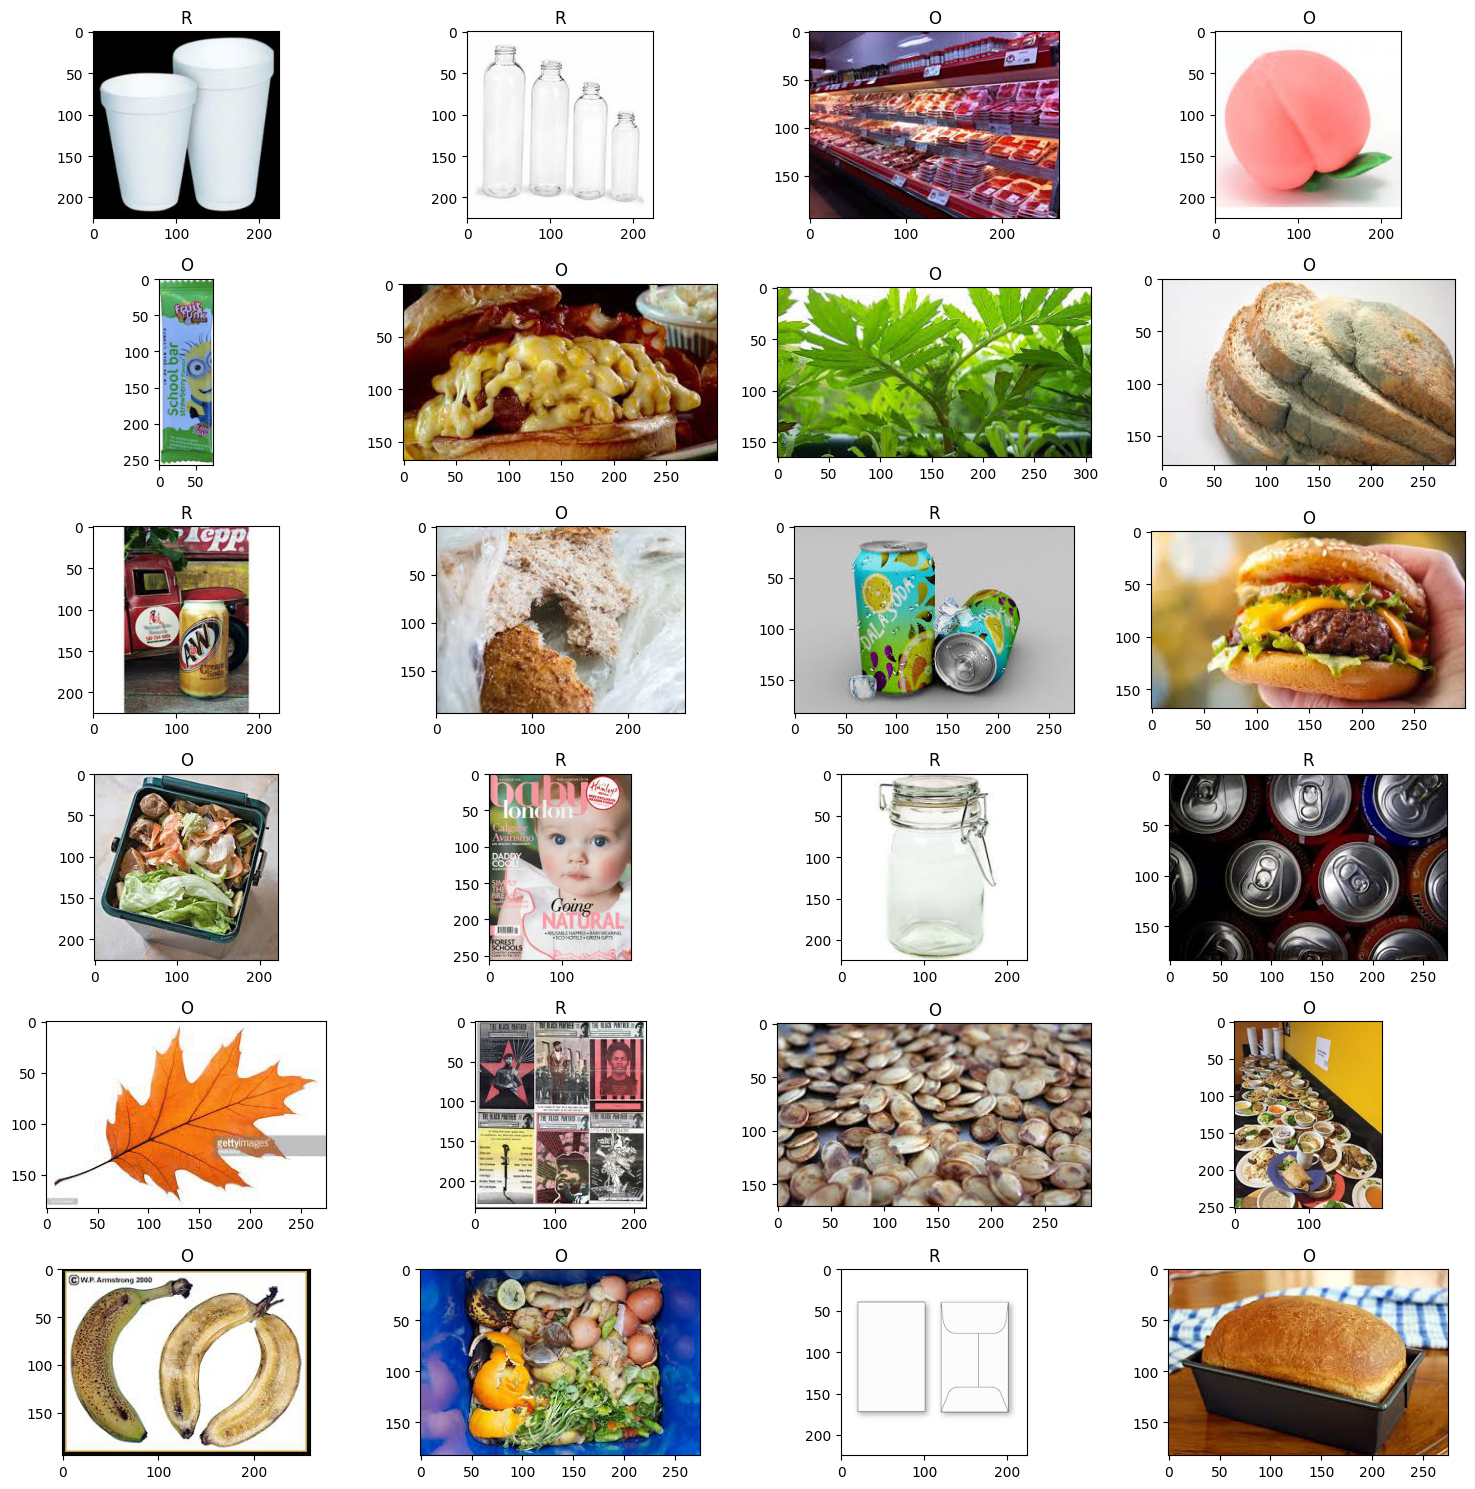

In [10]:
df_train = df_train.sample(frac=1).reset_index(drop=True)
fig, axes=plt.subplots(nrows=6,ncols=4,figsize=(15,15))

for i,ax in enumerate(axes.flat):
  x=plt.imread(df_train['filepaths'][i])
  ax.imshow(x)
  ax.set_title(df_train['labels'][i])
plt.tight_layout()
plt.show()

In [11]:
x = (df_train.labels == 'O').sum()
y = (df_train.labels == 'R').sum()

print("Label Oganic pada Dataset ada", x)
print("Label Non-Organic pada Dataset ada", y)

Label Oganic pada Dataset ada 12565
Label Non-Organic pada Dataset ada 9999


In [12]:
classes=['Organic','Non-Organic']

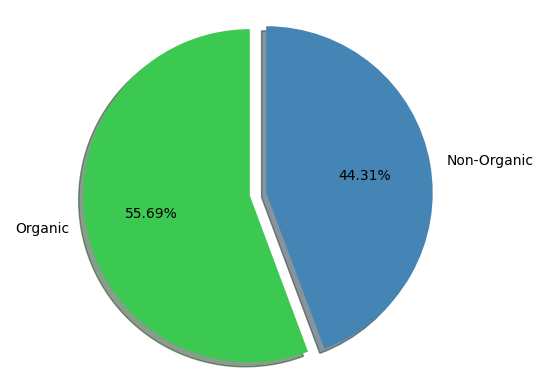

<Figure size 1000x800 with 0 Axes>

In [13]:
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = classes
sizes = [x, y]
colors = ['#3BC951','#4485B5']
explode = (0.05, 0.05)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
plt.figure(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%0.2f%%',
        shadow=True, startangle=90, colors=colors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

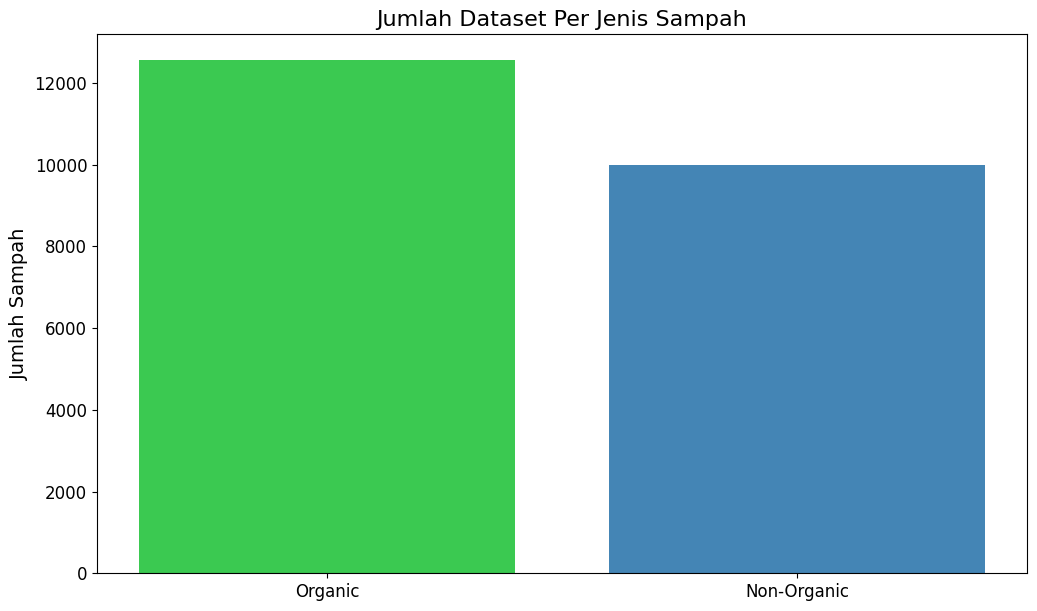

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

prodi = classes
jumlah_mhs = [x, y]
colors = ['#3BC951','#4485B5']

plt.figure(figsize=(12,7))
plt.bar(prodi, jumlah_mhs, color=colors)

plt.title('Jumlah Dataset Per Jenis Sampah', size=16)
plt.ylabel('Jumlah Sampah', size=14)
plt.xticks(size=12)
plt.yticks(size=12)

plt.show()

DATA PREPARTION (SPLIT TRAIN 70% DAN TEST 30%)

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   validation_split=0.2,
                                   horizontal_flip = True,
                                   fill_mode='nearest')

train_set = train_datagen.flow_from_dataframe(dataframe= df_train,
                                              x_col='filepaths',
                                              y_col='labels',
                                              target_size = (224, 224),
                                              batch_size = 32,
                                              seed=42,
                                              subset='training',
                                              shuffle=True,
                                              class_mode = 'categorical')

test_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.3)

test_set = test_datagen.flow_from_dataframe(dataframe= df_train,
                                            x_col='filepaths',
                                            y_col='labels',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            color_mode='rgb',
                                            seed=42,
                                            subset='validation',
                                            class_mode = 'categorical')

Found 18052 validated image filenames belonging to 2 classes.
Found 6769 validated image filenames belonging to 2 classes.


In [16]:
from tensorflow.keras.layers import Input

model = MobileNetV2(weights="imagenet", include_top=False,
                                input_tensor=Input(shape=(224, 224, 3)))

for layer in model.layers:
    layer.trainable = False

last_output = model.output

9406464/9406464 [==============================] - 0s 0us/step


In [17]:
x = tf.keras.layers.AveragePooling2D(pool_size=(7, 7))(last_output)
x = tf.keras.layers.Flatten(name="flatten")(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(2, activation="softmax")(x)



model = tf.keras.models.Model(model.input, x)

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [18]:
callback_cp = tf.keras.callbacks.ModelCheckpoint(
    filepath="/tmp/best-weights/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5", #hdf5 = h5 (versi singkat)
    monitor="val_accuracy",
    verbose=1,
    save_best_only=True,
    mode="max"
)
callback_es = tf.keras.callbacks.EarlyStopping(monitor='loss', restore_best_weights=True, patience=20)

In [19]:
optimizers = tf.keras.optimizers.Adam(learning_rate=0.0001)


model.compile(optimizer= optimizers ,loss = ('categorical_crossentropy'), metrics=['accuracy'])

history = model.fit(train_set,
                    epochs=6,
                    validation_data= test_set,
                    verbose=2,
                    callbacks=[callback_es, callback_cp],
                    validation_steps=5)

Epoch 1/6

Epoch 1: val_accuracy improved from -inf to 0.92500, saving model to /tmp/best-weights/weights-improvement-01-0.93.hdf5
565/565 - 1083s - loss: 0.3179 - accuracy: 0.8667 - val_loss: 0.2203 - val_accuracy: 0.9250 - 1083s/epoch - 2s/step
Epoch 2/6

Epoch 2: val_accuracy improved from 0.92500 to 0.94375, saving model to /tmp/best-weights/weights-improvement-02-0.94.hdf5
565/565 - 1056s - loss: 0.2081 - accuracy: 0.9204 - val_loss: 0.1749 - val_accuracy: 0.9438 - 1056s/epoch - 2s/step
Epoch 3/6

Epoch 3: val_accuracy improved from 0.94375 to 0.96875, saving model to /tmp/best-weights/weights-improvement-03-0.97.hdf5
565/565 - 999s - loss: 0.1866 - accuracy: 0.9278 - val_loss: 0.1510 - val_accuracy: 0.9688 - 999s/epoch - 2s/step
Epoch 4/6

Epoch 4: val_accuracy did not improve from 0.96875
565/565 - 1008s - loss: 0.1680 - accuracy: 0.9345 - val_loss: 0.2074 - val_accuracy: 0.9125 - 1008s/epoch - 2s/step
Epoch 5/6

Epoch 5: val_accuracy improved from 0.96875 to 0.97500, saving mod

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

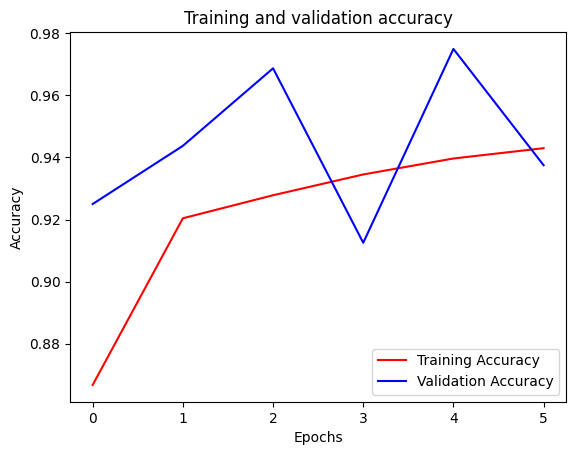

<Figure size 640x480 with 0 Axes>

In [21]:
plt.plot(epochs, acc, 'r', label ='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

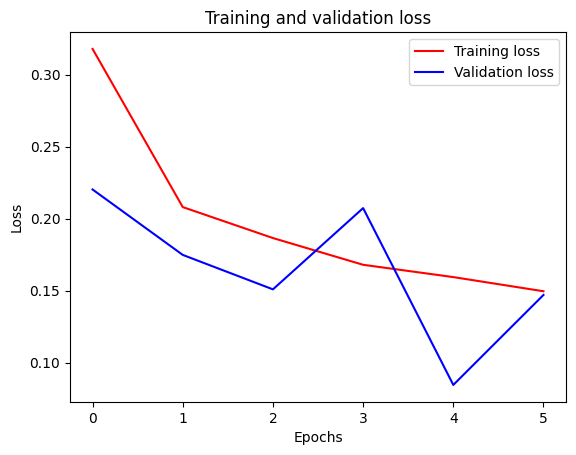

<Figure size 640x480 with 0 Axes>

In [22]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc=0)
plt.figure()
plt.show()

CEK CONFUSION MATRIX

212/212 [==============================] - 301s 1s/step


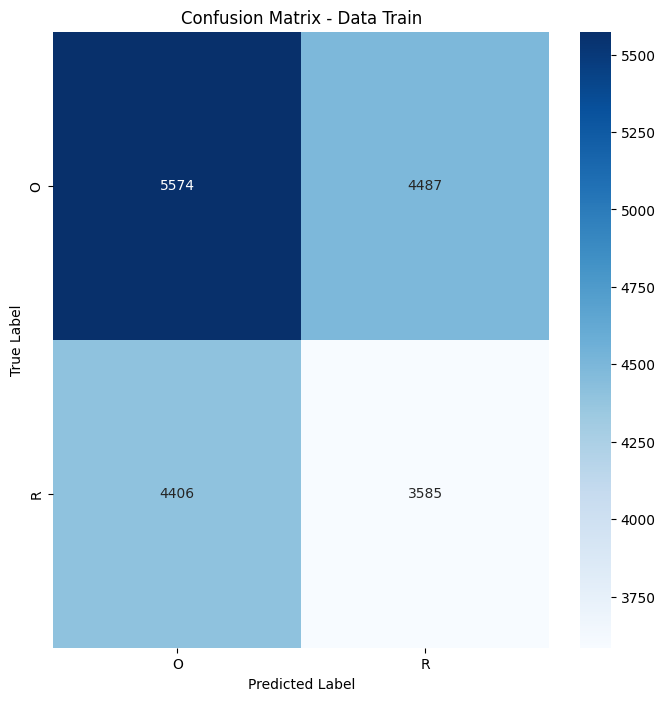

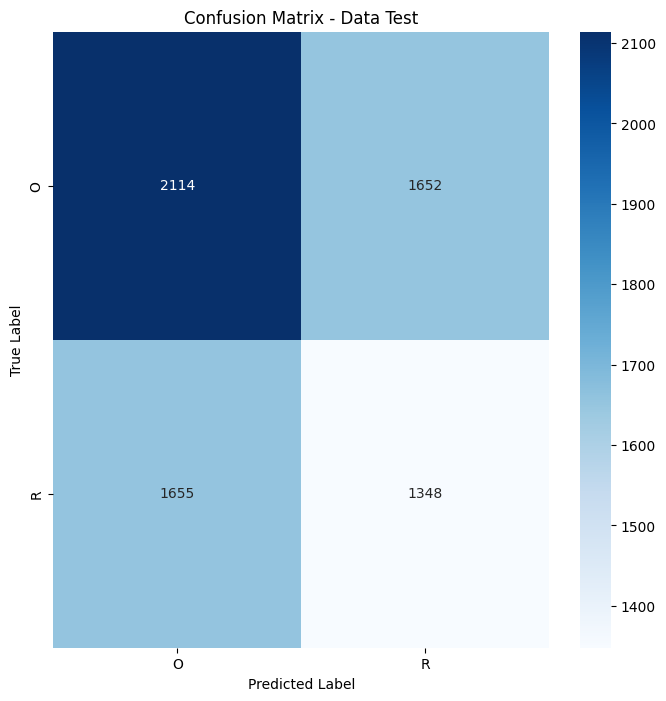

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Ambil hasil prediksi dari model terhadap data train
y_true_train = train_set.classes
y_pred_train = model.predict(train_set)
y_pred_train = np.argmax(y_pred_train, axis=1)

# Ambil hasil prediksi dari model terhadap data test
y_true_test = test_set.classes
y_pred_test = model.predict(test_set)
y_pred_test = np.argmax(y_pred_test, axis=1)

# Hitung confusion matrix untuk data train
cm_train = confusion_matrix(y_true_train, y_pred_train)

# Hitung confusion matrix untuk data test
cm_test = confusion_matrix(y_true_test, y_pred_test)

# Daftar label kelas (misal: ['class_0', 'class_1', ...])
class_labels = list(train_set.class_indices.keys())

# Plot confusion matrix untuk data train menggunakan heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Data Train')
plt.show()

# Plot confusion matrix untuk data test menggunakan heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Data Test')
plt.show()

MODEL EVALUATION

1/1 [==============================] - 2s 2s/step


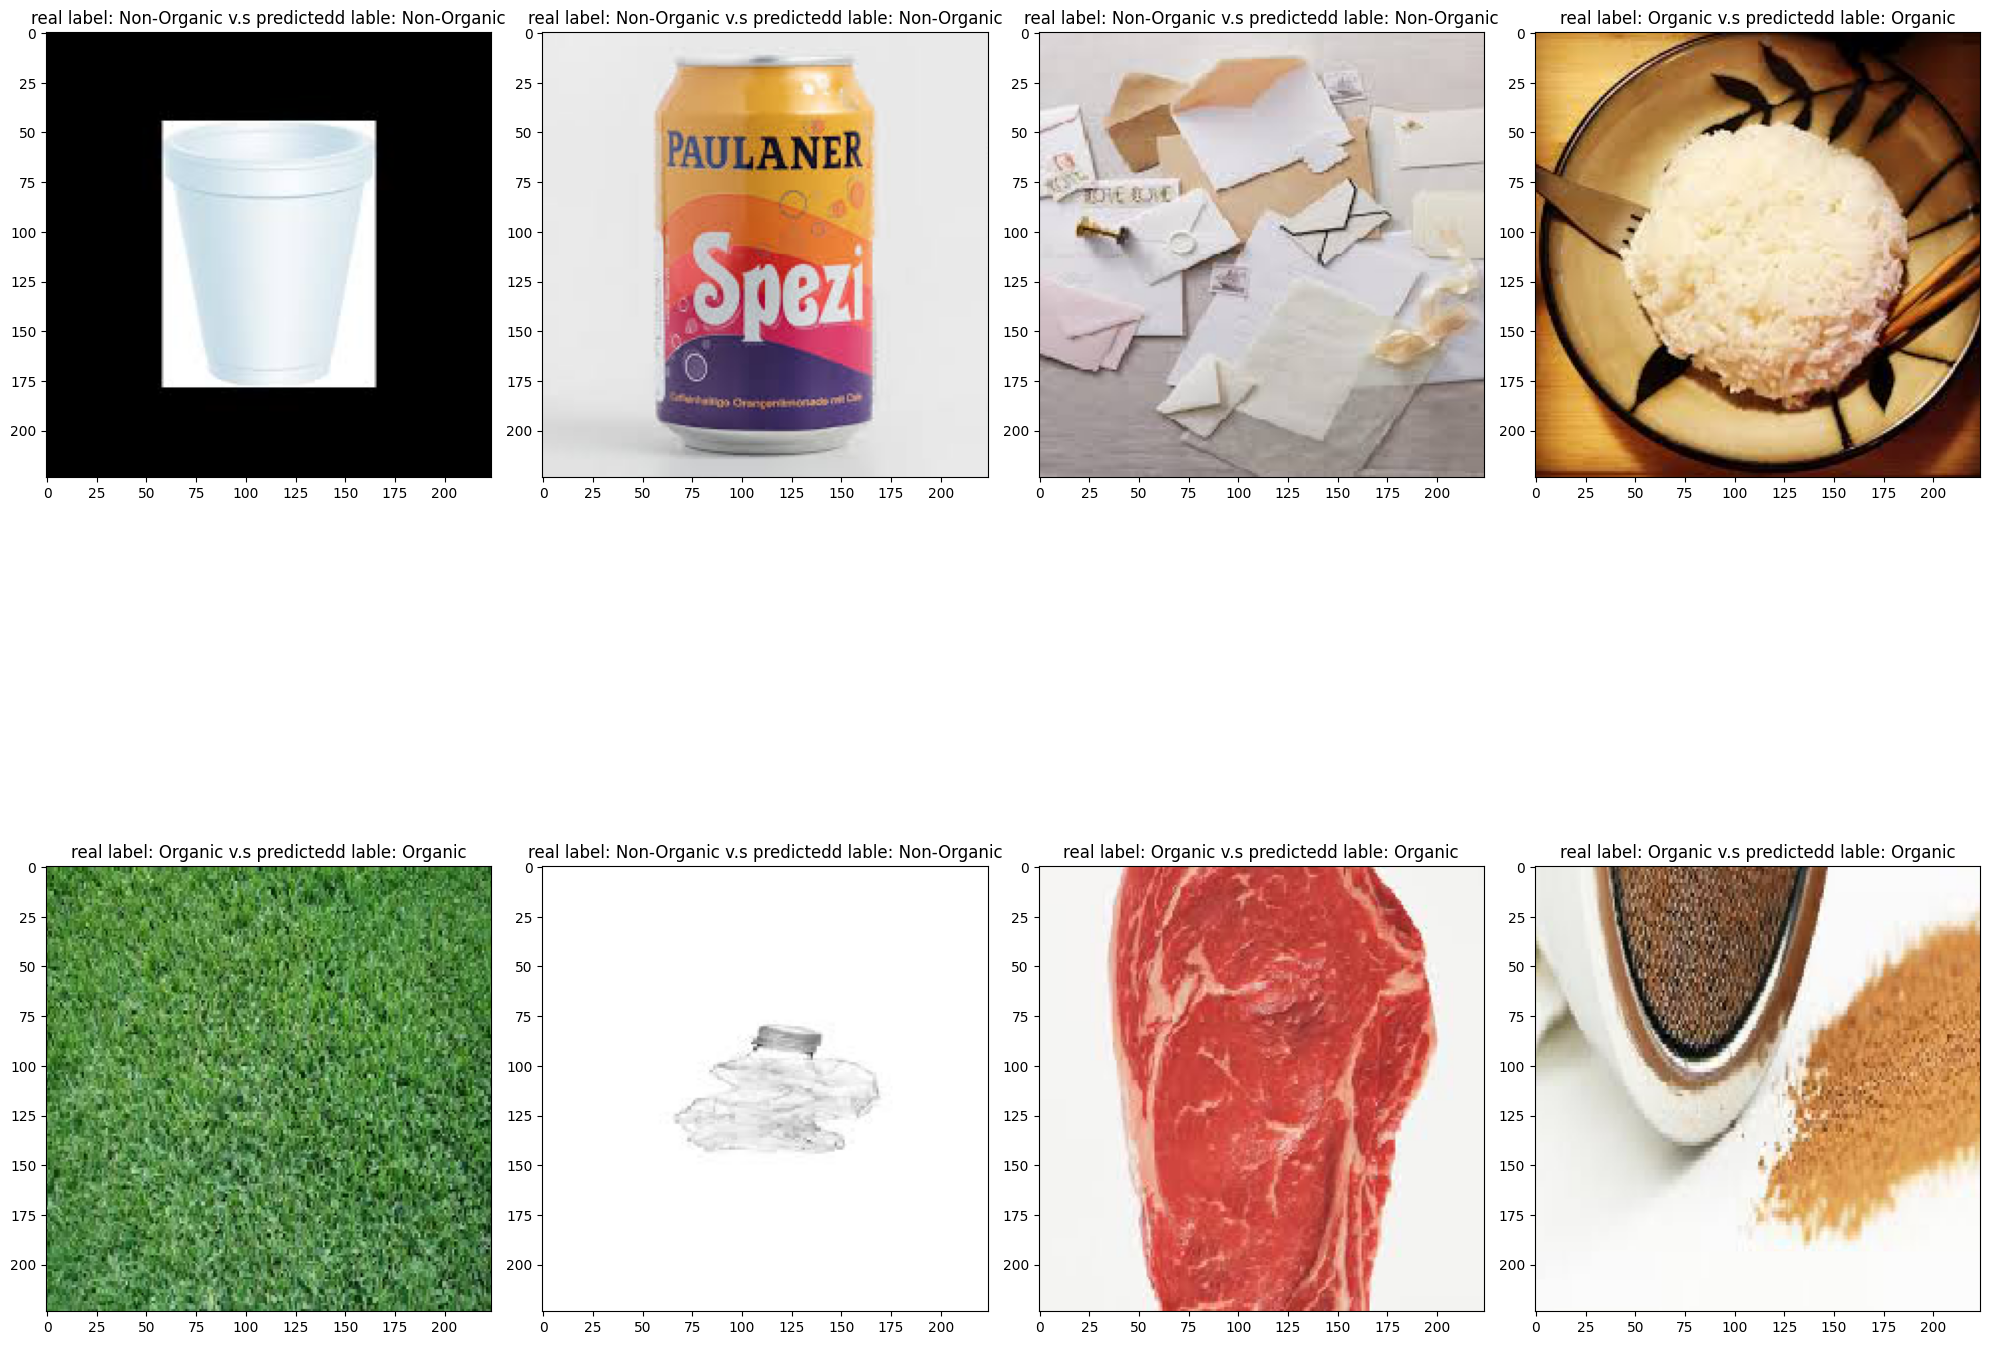

In [27]:
images, labels = test_set.next()
preds = model.predict(images)
fig,axes=plt.subplots(nrows=2,ncols=4,figsize=(20,20))
dic={i:ax for i,ax in enumerate(axes.flat)}
for i in range(0,8):
    label = np.argmax(labels[i])
    pred = np.argmax(preds[i])
    image = images[i]
    dic[i].set_title("real label: " + str(classes[label]) + " v.s " + "predictedd lable: " + str(classes[pred]))
    dic[i].imshow(image)
plt.tight_layout()
plt.show()